In [154]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append(os.path.abspath(".."))   # one level up
import numpy as np
import cv2
import open3d as o3d
from scipy.spatial.transform import Rotation
from utils.lidar import PointCloud
from utils.camera import ImageData
import utils.utils as utils
from natsort import natsorted, index_natsorted
import torch

################## set device based on cuda availability #################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('CUDA availability: ' + str(torch.cuda.is_available()))

CUDA availability: True


In [155]:
####################### Functions for matching using numpy on CPU or Pytorch on GPU ###################
def getMatchIndsCPU(ft_ref,ft_qry,topK=20,metric='cosine'):
    """
    metric: 'euclidean' or 'cosine'
    """
    # dMat = cdist(ft_ref,ft_qry,metric)

    ft_qry_norm = ft_qry / np.linalg.norm(ft_qry, axis=1, keepdims=True)  # Shape (M, N)
    ft_ref_norm = ft_ref / np.linalg.norm(ft_ref, axis=1, keepdims=True)  # Shape (C, N)

    # Step 2: Compute cosine similarity
    dMat = 1 - (ft_ref_norm @ ft_qry_norm.T)
    mInds = np.argsort(dMat,axis=0)[:topK].squeeze() # shape: K x ft_qry.shape[0]
    return mInds, dMat


def getMatchIndsGPU(ft_ref, ft_qry,topK=20, metric='cosine'):
    # metric: 'euclidean' or 'cosine'
    ft_qry_tensor = torch.Tensor(ft_qry).to(device)
    ft_ref_tensor = torch.Tensor(ft_ref).to(device)

    if metric == 'euclidean':
        # Use torch's cdist for Euclidean distance
        dMat = torch.cdist(ft_ref, ft_qry)
    
    elif metric == 'cosine':
        # # Normalize both the query and reference tensors
        ft_qry_norm = ft_qry_tensor / ft_qry_tensor.norm(dim=1, keepdim=True)
        ft_ref_norm = ft_ref_tensor / ft_ref_tensor.norm(dim=1, keepdim=True)
        # Compute cosine similarity (1 - cosine similarity for distance)
        dMat = 1 - ft_ref_norm @ ft_qry_norm.t()

    # Get the indices of the top 5 closest matches
    mInds = torch.argsort(dMat, dim=0)[:topK].squeeze()
    
    return mInds, dMat

In [156]:
# User parameters
vpr_desc = 'cosplace'
# location = 'Holmview'
location = 'Cambogan'

################ Query filenames and directories #################################
# qry_sequence = '20250820_130327'
qry_sequence = '20250811_113017'
qry_condition = 'flooded'
# qry_sequence = '20250812_122339'
# qry_condition = 'dry'
qry_camera_pos = 'front'
qry_root_directory = f"../../Datasets/FRED/{qry_condition}/KITTI-style"
qry_vpr_root = f"../../Datasets/FRED/vpr_ftrs/{qry_condition}/KITTI-style"

qry_image_dir = f"{qry_root_directory}/{location}_{qry_sequence}/{qry_camera_pos}-imgs/"
qry_utm_dir = f"{qry_root_directory}/{location}_{qry_sequence}/utm/"
qry_timestamps = [filename.split('.png')[0] for filename in natsorted(os.listdir(qry_image_dir)) if os.path.isfile(qry_image_dir+filename)]
qry_name_sort_idx = index_natsorted(os.listdir(qry_image_dir))
qry_ftrs = np.load(f"{qry_vpr_root}/{location}_{qry_sequence}/{vpr_desc}/queries_descriptors.npy")
qry_ftrs = qry_ftrs[qry_name_sort_idx]

################ Reference filenames and directories #################################
# ref_sequence = '20250812_120100'
ref_sequence = '20250812_122339'
ref_condition = 'dry'
ref_camera_pos = 'front'
ref_root_directory = f"../../Datasets/FRED/{ref_condition}/KITTI-style"
ref_vpr_root = f"../../Datasets/FRED/vpr_ftrs/{ref_condition}/KITTI-style"

ref_image_dir = f"{ref_root_directory}/{location}_{ref_sequence}/{ref_camera_pos}-imgs/"
ref_utm_dir = f"{ref_root_directory}/{location}_{ref_sequence}/utm/"
ref_timestamps = [filename.split('.png')[0] for filename in natsorted(os.listdir(ref_image_dir)) if os.path.isfile(ref_image_dir+filename)]
ref_name_sort_idx = index_natsorted(os.listdir(ref_image_dir))
ref_utms = np.array([np.loadtxt(ref_utm_dir+filename) for filename in natsorted(os.listdir(ref_utm_dir)) if os.path.isfile(ref_utm_dir+filename)])
ref_img_filenames = [filename for filename in natsorted(os.listdir(ref_image_dir)) if os.path.isfile(ref_image_dir+filename)]
ref_utm_filenames = np.array([filename for filename in natsorted(os.listdir(ref_utm_dir)) if os.path.isfile(ref_utm_dir+filename)])
ref_ftrs = np.load(f"{ref_vpr_root}/{location}_{ref_sequence}/{vpr_desc}/queries_descriptors.npy")
ref_ftrs = ref_ftrs[ref_name_sort_idx]

img_calib_file = f"../camera_calib.txt"

dist_tolerance = 10 # metres
qry_idx = 4

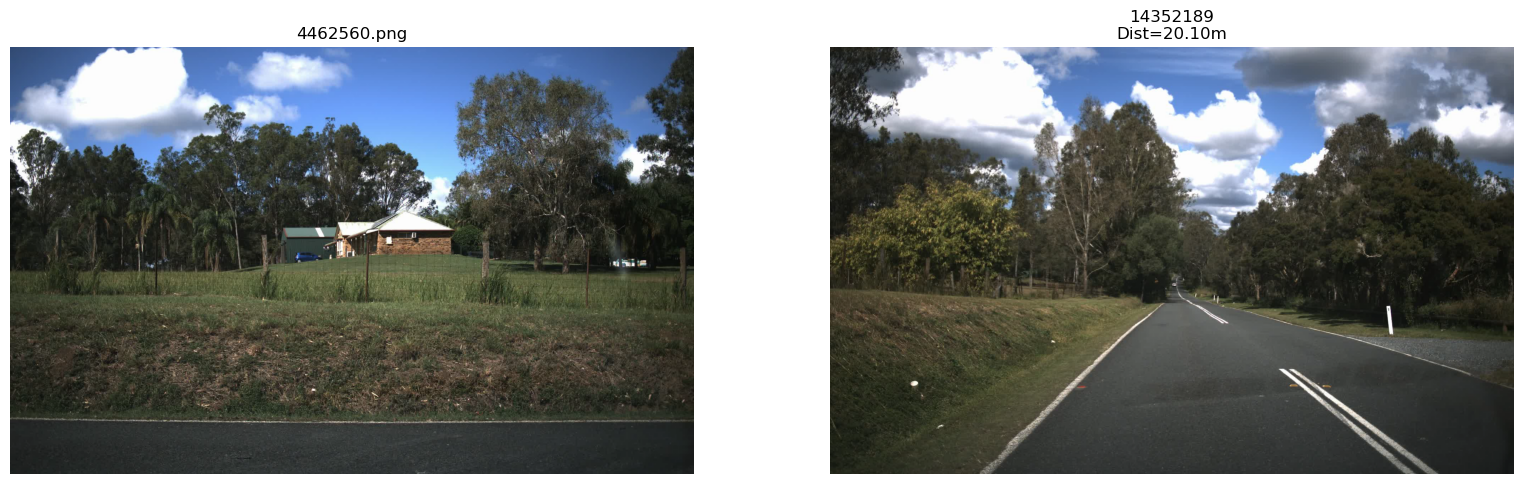

In [157]:
qry_image_timestamp = qry_timestamps[qry_idx]
qry_image_filename = f"{qry_image_dir}/{qry_image_timestamp}.png"
qry_utm_timestamp = utils.get_corr_files(qry_image_timestamp, [qry_utm_dir,])
qry_utm = np.loadtxt(qry_utm_timestamp)

mInds, dMat = getMatchIndsGPU(ref_ftrs,qry_ftrs,topK=1)

mInds = mInds.cpu().numpy()

# print(f"Number of queries: {len(qry_timestamps)}")
# print(f"Number of references{ {len(ref_timestamps)}}")
# print(f"Matche  {mInds[qry_idx]}")
# print(natsorted(os.listdir(qry_image_dir)))
# print(os.listdir(qry_image_dir))

ref_utm_timestamp = utils.get_corr_files(ref_timestamps[int(mInds[qry_idx])], [ref_utm_dir,])
ref_utm = np.loadtxt(ref_utm_timestamp)

diff = ref_utm - qry_utm           # shape (N, 2)
dist = np.linalg.norm(diff)   # shape (N,)

qry_image = ImageData(qry_image_filename, img_calib_file)

fig, ax = plt.subplots(1, 2, figsize=(19.4, 6))
ax[0].clear()
ax[1].clear()

ax[0].imshow(qry_image.image[:, :, ::-1])
ax[0].set_title(f"{qry_image_timestamp}.png")
ax[0].axis("off")

# Show matching reference image
# ref_img_timestamp = utils.get_corr_files(ref_timestamps[int(mInds[qry_idx])], [ref_image_dir,])
ref_image = ImageData(f"{ref_image_dir}/{ref_timestamps[int(mInds[qry_idx])]}.png", img_calib_file)
ax[1].imshow(ref_image.image[:, :, ::-1])
ax[1].set_title(f"{ref_timestamps[int(mInds[qry_idx])]}\nDist={dist:.2f}m")

ax[1].axis("off")
fig.canvas.draw()